In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from time import time

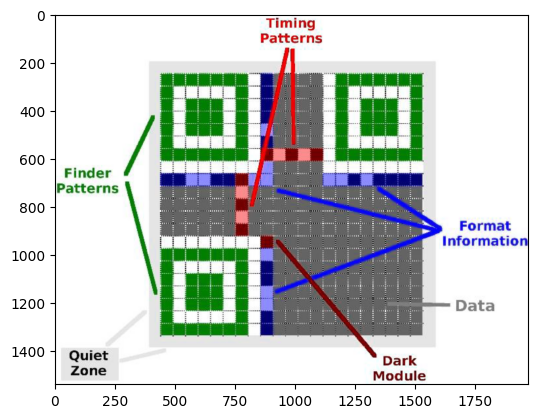

In [2]:
image = cv2.imread("qr_spec.webp")
plt.imshow(image)

### Алгоритм

Finder pattern (FP) для QR-кода состоит из трех вложенных друг в друга квадратов с соотношением сторон 3:5:7 (см. картинку выше).
Соотношение площадей этих квадратов равно 9:25:49, соответсвенно найдя три контура с таким отношением площадей мы найдем FP.

Алгоритм будет состоять из 3 этапов:
- применить фильтр к изображению
- выделить все контуры
- выбрать те контуры, которые вложены друг в друга и имеют соотношение около 9:25:49.

У полученного набора контуров обведем наибольший, чтобы выделить на изображении найденный FP.

При подсчете метрик precision и recall будем рассматривать каждый блок по отдельности, т.е. если алгоритм нашел на картинке с одним QR-кодом 2 из 3 pattern finder блоков и ошибочно 3 лишних контура, то 
- $precision=\frac{2}{5}=0.4$
- $recall=\frac{2}{3}=0.66666666$

In [3]:
GAUSS_KERNEL_SIZE = 11
THRESHOLD_BLOCK_SIZE = 11
THRESHOLD_C = 2
MORPH_KERNEL = np.ones((4, 4), np.uint8)
ERODE_KERNEL =  np.ones((3, 3), np.uint8)
ERODE_ITER = 1

CANNY_LOWER = 80
CANNY_UPPER = 110
DILATE_KERNEL = np.ones((3, 3))

AREA_THRESHOLD_RATE = 0.15
CONTOUR_WIDTH = 3
CONTOUR_HIERARCHY_MIN = 3
CONTOUR_HIERARCHY_MAX = 7

BIG_AREA = 49
MID_AREA = 25
LIL_AREA = 9

MIN_CH_VAL = 0
MAX_CH_VAL = 255

In [4]:
def print_image(image):
    plt.figure(figsize = (20,10))
    plt.imshow(image, interpolation='nearest')

def preprocess_image(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_image = cv2.GaussianBlur(gray_image, (GAUSS_KERNEL_SIZE, GAUSS_KERNEL_SIZE), 0)
    # gray_image = cv2.bilateralFilter(gray_image, 15, 17, 17)
    gray_image= cv2.adaptiveThreshold(gray_image, MAX_CH_VAL, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, THRESHOLD_BLOCK_SIZE, THRESHOLD_C)
    gray_image = cv2.morphologyEx(gray_image, cv2.MORPH_CLOSE, MORPH_KERNEL)
    gray_image = cv2.erode(gray_image, ERODE_KERNEL, iterations=ERODE_ITER)
    return gray_image


def get_edges(gray_image):
    edges = cv2.Canny(gray_image, CANNY_LOWER, CANNY_UPPER)
    edges = (edges != 0).astype(np.uint8)
    edges = cv2.dilate(edges, DILATE_KERNEL)
    return edges


def check_fp_area_proportions(areas, threshold_rate):
    outer_black_area = areas[0]
    for i, inner_white_area in enumerate(areas[1 : -1]):
        for inner_black_area in areas[i + 1:]:
            is_ratio_1 = np.abs(outer_black_area / inner_white_area - BIG_AREA / MID_AREA) < BIG_AREA / MID_AREA * threshold_rate
            is_ratio_2 = np.abs(outer_black_area / inner_black_area - BIG_AREA / LIL_AREA) < BIG_AREA / LIL_AREA * threshold_rate
            if is_ratio_1 and is_ratio_2:
                return True
    return False

def get_fp_contours(contours, hierarchy):
    processed_contours_ids_total = set()
    fp_contours = []
    for i, contour in enumerate(contours):
        if i in processed_contours_ids_total:
            continue
            
        areas = [] # contains nested contours from out to inside order
        processed_contours_ids = set()
        
        j = i
        while hierarchy[j][2] != -1: # hierarchy[j][2] returns first child contour 
            areas.append(cv2.contourArea(contours[j]))
            processed_contours_ids.add(j)
            j = hierarchy[j][2]
            
        if CONTOUR_HIERARCHY_MIN < len(areas) < CONTOUR_HIERARCHY_MAX:
            if check_fp_area_proportions(areas, AREA_THRESHOLD_RATE):
                fp_contours.append(contour)
                processed_contours_ids_total.union(processed_contours_ids)
                
    return fp_contours

## Итоговый запуск

In [5]:
def fp_detector(image):
    gray_image = preprocess_image(image)
    edges = get_edges(gray_image)
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    fp_contours = get_fp_contours(contours, hierarchy[0])
    cv2.drawContours(image, fp_contours, -1, (MIN_CH_VAL, MIN_CH_VAL, MAX_CH_VAL), CONTOUR_WIDTH)
    return image

def process_folder(input_folder, output_folder):
    input_file_list = os.listdir(input_folder)
    start = time()
    for file in input_file_list:
        image = cv2.imread(input_folder + '/' + file)

        result = fp_detector(image)

        if not os.path.exists(output_folder):
            os.mkdir(output_folder)
        cv2.imwrite(output_folder + '/' + file, result)
    end = time()
    print("Среднее время затраченное на одну картинку - {:.3f} секунд".format((end - start) / len(input_file_list)))

In [6]:
process_folder("TestSet1", "ResultSet1")
process_folder("TestSet2", "ResultSet2")
process_folder("TestSet3", "ResultSet3")

## Результаты

**TestSet1**
- Precision: 0.94 
- Recall: 0.85

**TestSet2**
- Precision: 0.94
- Recall: 0.86

## Контрольное тестирование детектора

**TestSet3**
- Precision: 0.47
- Recall: 0.30

## Анализ

Для датасета `TestSet3` значения метрик значительно ниже, чем для датасетов `TestSet1` и `TestSet2`. При подсчете метрик для `TestSet3` я заметил, что большое кол-во ошибок связано с тем, что в большом кол-ве случаев для внешнего черного слоя finder-pattern-а определяется внутренний контур, а не внешний, как на приведенном ниже примере:

<img src="./defected_result.jpg" style="height: 300px; width:300px;"/>

Т.к. FP используются для определения положения и ориентации QR-кода, то не обязательно находить именно внешний контур внешнего черного слоя, достаточно лишь знать координаты центров трех FP. Для получения центров нам подходит, как внешний, так и внутренний контур слоев FP. 

Отсюда следует, что можносчитать найденный внутренний контур, как true-positive ответ. Осталось разрешить проблему, когда для одного и того же FP был детектирован и внешний, и внутренний контуры. В таком случае внутренний контур можно легко детектировать либо путем проверки вложенности, либо путем сравнения центров FP полученных для двух контуров. Т.к. данная проблема решается путем пост-обработки результата будем считать, что случай когда найдены и внешний, и внутренний контуры - true-positive.

Полученные таким образом метрики будем обозначать, как `Precision*` и `Recall*`. Посчитаем эти метрики для всех трех датасетов:

**TestSet1**
- Precision*: 1.00
- Recall*: 0.87

**TestSet2**
- Precision*: 1.00
- Recall*: 0.86

**TestSet3**
- Precision*: 0.96
- Recall*: 0.55

## Вывод
- По результатам контрольного тестирования получили значительное снижение метрик для контрольного датасета: `Precision` на 50% и `Recall` на 64%. 
- При анализе результата было замечено, что есть множество результатов работы детектора, которые трактовались, как false-positive, однако путем путем дополнительной постобработки можно уже считать их true-positive. 
- Исходя из этого ввели альтернативный способ подсчета целевых метрик `Precision*` и `Recall*`, которые показали, что при наличии постобработки `Precision*` падает на 4%, а `Recall*` на 38%. Как видим `Recall*` все еще показывает ощутимое ухудшение результата. 
- Эту проблему постобработкой результата детектора не решить, т.к. падение связано с тем, что детектор не находит FP. Чтобы решить эту проблему нужно улучшать уже сам детектор.